In [39]:
%run PVModel_functions.ipynb

In [40]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [41]:
#This is where all the input info should be
#Valid module names : LG, Panasonic, Can270, Can275, HanQPlus, HanQPeak, MissionSolar, Jinko
#Valid sys table names: dbo.PVLT_Pan_LG_Panasonic_LG,dbo.PVLT_Can_Han_Canadian_Hanwha,
#                       dbo.PVLT_TrinaJinko_Jinko, dbo.PVLT_MissionSolar_MissionSolar
#They won't all work yet because info that is called from df is still module specific at this phase (ex: df['PH1_RTD_Avg'])

mod_name = 'Can275'
mettablename =  'dbo.SNLA_Met_DataOut'
systablename =  'PVLT_Can_Han_Canadian_Hanwha'

In [42]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
module = mod_info[mod_name]
start = module['start']
end = module['end']

In [43]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

In [44]:
#Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
#merge this information into one solar & environmental data df called 'sedf'
sedf = pd.merge(edf,sdf,how='inner', left_index=True, right_index=True)

In [45]:
#Generate a results dataframe and add measured values
results = meas_val(df[module['str_1_v']],df[module['str_1_i']])
results = results.to_frame()

In [46]:
#read in SAM data from the spreadsheet containing all SAM results for entire time period of system
sam_data = pd.read_excel('SAM_results.xlsx', sheet_name = [mod_name])
sam_data = sam_data[mod_name]
sam_data.index = sam_data['Time']
del sam_data['Time']
sam_data.rename(columns = {mod_name : 'SAM'}, inplace = True)
results['SAM'] = sam_data['SAM']

In [47]:
#Calcualte SAPM results and add to df
sapm_par = sapm_param(sedf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.AmbientTemp_Avg, df.Wind_Speed_Avg, 
                   sedf['am_abs'], sedf['aoi'], module)
dc = sapm(sapm_par['eff_irr'], sapm_par['tcell'], module)
results['SAPM'] = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len'])

In [48]:
#Calculate PVWatts results and add to df
results['PVWatts'] = pvwatts(POA_eff = df['BroadbandPOA_Avg'], cell_temp = df[module['str_1_rtd']], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'], temp_ref=25.0 )

In [49]:
#Calculate CEC results and add to df
cec_param = pvlib.pvsystem.calcparams_cec( df['BroadbandPOA_Avg'], df[module['str_1_rtd']], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4])
results['CEC'] = sdm(cec_p['p_mp'], module['str_len'])

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\singlediode.py:613: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /


In [50]:
#Calculate Desoto results and add to df
ds_param = pvlib.pvsystem.calcparams_desoto(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4])
results['Desoto'] = sdm(ds_p['p_mp'], module['str_len'])

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\singlediode.py:690: RuntimeWarning: invalid value encountered in multiply
  return I * df[loc]


In [51]:
#Calculte PVSystem results and add to df
pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4])
results['PVSyst'] = sdm(pvs_p['p_mp'], module['str_len'])

Text(0, 0.5, 'Power (W)')

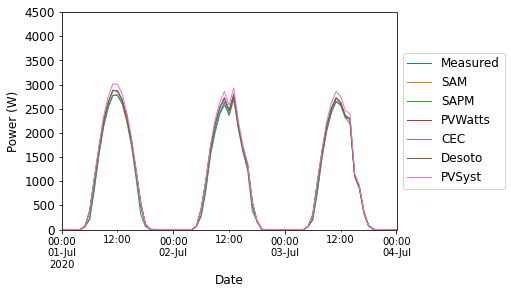

In [52]:
#Plot just for fun
results.rename(columns = { 0 : 'Measured'}, inplace = True)
results.plot()
plt.xlim('2020-07-01', '2020-07-04')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')